In [1]:
import random

from data_processing import csv_data_processing
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Parameters for algorithm
n_iter=10
k=2

# Data Processing with dedicated class
cdp=csv_data_processing()
database=cdp.process_data('clustering.csv')
database_drop=database.drop(columns='Loan_ID').astype(float)
X_org=database[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']].copy()

# plt.scatter(database_drop['ApplicantIncome'], database_drop['LoanAmount'])

fig2d=scatter_matrix(X_org, alpha=0.1, figsize=(5,5), diagonal='hist', range_padding=0.5)
for ax in fig2d.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha("right")

KeyboardInterrupt: 

     ApplicantIncome  CoapplicantIncome  LoanAmount
0               4583             1508.0       128.0
1               3000                0.0        66.0
2               2583             2358.0       120.0
3               6000                0.0       141.0
4               2333             1516.0        95.0
..               ...                ...         ...
376             5703                0.0       128.0
377             3232             1950.0       108.0
378             2900                0.0        71.0
379             4106                0.0        40.0
380             4583                0.0       133.0

[381 rows x 3 columns]
[[0.7074687653173045, -0.40893220627486027, -0.7030188804087407, 1.7067992623142074, -0.8793298361244963, -0.26788344170225575, -0.7615541177063716, -1.2178468710987471, -1.6085519489648616, 0.9662932483080338, 0.011393112151501196, -0.049257856614718744, 0.9218628874676633, -0.6910297354200693, 2.877504008266825, -0.6910297354200693, -0.151518210929

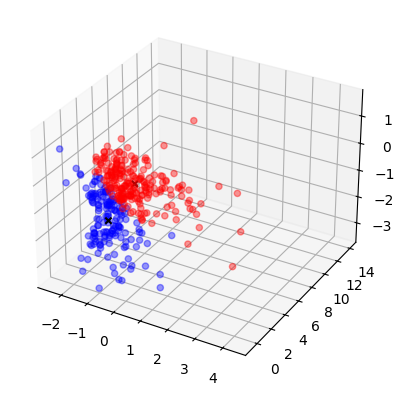

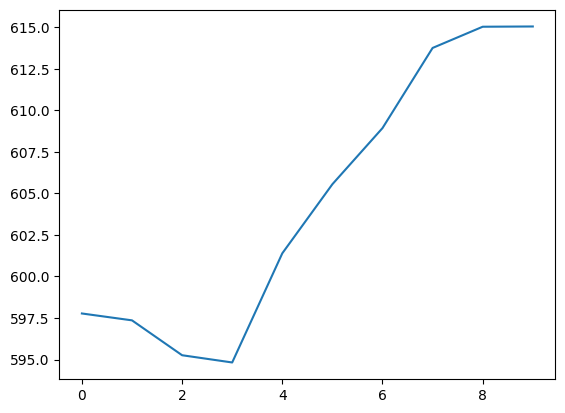

In [ ]:
centr_index=[]
inertia=[]

print(X_org)

data=[]
for column in X_org:
    col=[]
    for iter, item in enumerate(X_org[column]):
        col.append((item-np.mean(X_org[column]))/np.std(X_org[column]))
    data.append(col)

print(data)

# sscaler=StandardScaler()
# X=sscaler.fit_transform(X_org)

X=pd.DataFrame(np.transpose(data))
X=X.rename(columns={0: "ApplicantIncome", 1: "CoapplicantIncome", 2: "LoanAmount"})

print(X)

for i in range(0, k):
        centr_index.append(random.randint(0, X.shape[0]))

centroids=[]
for i in centr_index:
    centroids.append([X['ApplicantIncome'][i], X['CoapplicantIncome'][i], X['LoanAmount'][i]])

centroids=pd.DataFrame(centroids)

for i in range(0, n_iter):
    # K-means        
    # fig=plt.figure()
    # ax=fig.add_subplot(projection='3d')
    # ax.scatter(X['ApplicantIncome'], X['CoapplicantIncome'], X['LoanAmount'], marker='o', label='data points', alpha=0.3)
    # ax.scatter(centroids[0], centroids[1], centroids[2], c='red', marker='x', label='centroids')
    # plt.legend(loc='upper left')
    # fig.show()

    # print(centroids)

    dist_all=[]
    for iter, idx in enumerate(X.index):
        for i in range(0,k):
            distance=np.sqrt((centroids[0][i] - X['ApplicantIncome'][idx])**2 + (centroids[1][i] - X['CoapplicantIncome'][idx])**2 + (centroids[2][i] - X['LoanAmount'][idx])**2)
            dist_all=np.append(dist_all, distance)

    dist_all=dist_all.reshape(len(X), k)

    # print(np.shape(dist_all))

    labels=[]
    for point in dist_all:
        labels.append(np.where(point==min(point))[0][0].astype(float))

    print(labels)

    X.loc[:, 'class']=labels

    X=X.sort_values(by=['class'], ascending=True)

    class_border=[]
    cla=0
    for iter, idx in enumerate(X.index):
        if X['class'][idx] != cla:
            class_border.append(iter)
            cla=+1

    centroids.loc[0, :]=[np.mean(X['ApplicantIncome'][0:class_border[0]-1]).astype(float), np.mean(X['CoapplicantIncome'][0:class_border[0]-1]).astype(float), np.mean(X['LoanAmount'][0:class_border[0]-1]).astype(float)]
    centroids.loc[1, :]=[np.mean(X['ApplicantIncome'][class_border[0]:-1]).astype(float), np.mean(X['CoapplicantIncome'][class_border[0]:-1]).astype(float), np.mean(X['LoanAmount'][class_border[0]:-1]).astype(float)]
    
    intra_cluster=0
    for idx in range(0, class_border[0]-1):
        intra_sol=np.sqrt((centroids[0][0] - X['ApplicantIncome'][idx])**2 + (centroids[1][0] - X['CoapplicantIncome'][idx])**2 + (centroids[2][0] - X['LoanAmount'][idx])**2)
        intra_cluster=intra_cluster+intra_sol

    for idx in range(class_border[0], len(X)):
        intra_sol=np.sqrt((centroids[0][1] - X['ApplicantIncome'][idx])**2 + (centroids[1][1] - X['CoapplicantIncome'][idx])**2 + (centroids[2][1] - X['LoanAmount'][idx])**2)
        intra_cluster=intra_cluster+intra_sol

    inertia.append(intra_cluster)

    
fig_class=plt.figure()
ax_class=fig_class.add_subplot(projection='3d')
ax_class.scatter(X['ApplicantIncome'][0:class_border[0]-1], X['CoapplicantIncome'][0:class_border[0]-1], X['LoanAmount'][0:class_border[0]-1], marker='o', label='data points class 0', alpha=0.4, c="blue")
ax_class.scatter(X['ApplicantIncome'][class_border[0]:-1], X['CoapplicantIncome'][class_border[0]:-1], X['LoanAmount'][class_border[0]:-1], marker='o', label='data points class 1', alpha=0.4, c="red")
ax_class.scatter(centroids[0][:], centroids[1][:], centroids[2][:], marker='x', label='centroids', alpha=1, c="black")

# print(inertia)

fig_inertia=plt.figure()
ax_inertia=fig_inertia.add_subplot()
ax_inertia.plot(inertia)

[[ 0.70746877  0.09869541  0.81257519]
 [-0.40893221 -0.5463709  -1.37659578]
 [-0.70301888  0.4622938   0.53010151]
 ...
 [-0.47945659 -0.5463709  -1.20004974]
 [ 0.37106746 -0.5463709  -2.29463522]
 [ 0.70746877 -0.5463709   0.98912123]]
Initialization complete
Iteration 0, inertia 987.3193645768818.
Iteration 1, inertia 840.9314161903967.
Iteration 2, inertia 838.526603226344.
Iteration 3, inertia 837.3919613316406.
Iteration 4, inertia 836.4906564352485.
Iteration 5, inertia 836.2077642146219.
Iteration 6, inertia 835.9969961629922.
Iteration 7, inertia 835.8841545757634.
Iteration 8, inertia 835.7390932028102.
Iteration 9, inertia 835.4654928490618.
Iteration 10, inertia 835.367035088721.
Converged at iteration 10: center shift 5.538628344047119e-05 within tolerance 0.0001.
835.334251992466


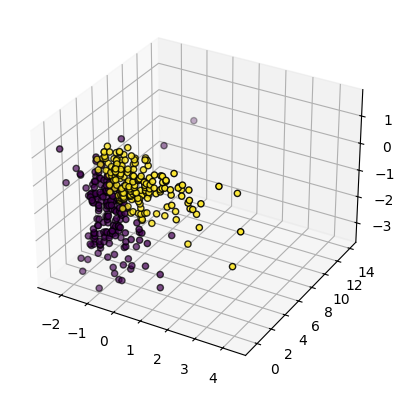

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

sscaler=StandardScaler()
X_fit=sscaler.fit_transform(X_org)

print(X_fit)

pd.DataFrame(X_fit).describe()

kmeans=KMeans(n_clusters=2, verbose=2)

kmeans.fit(X_fit)

print(kmeans.inertia_)

labels=kmeans.labels_

fig_skl=plt.figure()
ax_skl=fig_skl.add_subplot(projection='3d', azim=-60)

ax_skl.scatter(X_fit[:,0], X_fit[:,1], X_fit[:,2], c=labels.astype(float), edgecolor="k")